# Defining the Architecture & Training the Network

## Defining the Convolutional Neural Network

After we've looked at the data and, in this case, know the shapes of the images and of the keypoints, we ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, I will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And we'll see examples of this later in the notebook.

## CNN Architecture

I will use the Convolutional, Maxpooling, and Fully-connected layers and add multiple convolutional layers and things like dropout layers that may prevent overfitting. I have also consulted the literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help determine the structure of the network.

## PyTorch Neural Nets

To define a neural network in PyTorch, we define the layers of a model in the function `__init__` and define the feed-forward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feed-forward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### models.py
I have implemented several architectures (e.g. Resnet, VGG, SqueezeNet, etc.) in the `models.py` file. In this notebook, I will use a simple CNN architecture written as `Net` class in the `models.py`. *You can test more complex networks and also transfer learning in the notebook __2_1_Training_complex_models__*. 
So any models we've defined can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, we can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

# Once we've define the network, we can instantiate it
from models import Net
import cv2

# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsDataset


# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# !mkdir data
# !wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip -n data/train-test-data.zip -d data

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

## Transform the dataset 

To prepare for training, we need to create a transformed dataset of images and keypoints.

### Defining a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so the model's loss does not blow up during training. It is also useful to normalize the input images and keypoints.

To define the data transform below, I used a [composition:](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that images become squared (here 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `transform.py`. **This transform will be applied to the training data and, later, the test data**. It will change how we go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, we can perform **data augmentation**. That's we randomly rotate or shift the images. A square image size will be useful here; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

# testing that we've defined a transform
assert data_transform is not None, "Define a data_transform"

In [5]:
training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)


print("Number of images: ", len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["keypoints"].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. Find out more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
We can try both small and large batch sizes and check how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with the DataLoader failing.

In [7]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

## Before training

Let's take a look at how this model performs before it trains. We can easily see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that we can compare it to the model after training and see how the model has improved.

#### Loading in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how the model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# loading in the test data, using the dataset class, and apply the data_transform we defined above

# creating the test dataset
test_dataset = FacialKeypointsDataset(
    csv_file=test_keypoints_csv_path, root_dir=test_data_dir, transform=data_transform
)

In [9]:
# loading test data in batches
batch_size = 16

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

## Applying the model on a test sample

To test the model on a test sample of data, I will apply the following steps:
1. Extracting the image and ground truth keypoints from a sample
2. Making sure the image is a FloatTensor, which the model expects.
3. Forwarding pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images
def net_sample_output(model, test_loader):

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # getting sample data: images and ground truth keypoints
        images = sample["image"]
        key_pts = sample["keypoints"]

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forwarding pass to get net output
        output_pts = model(images)

        # reshaping to batch_size x 68 x 2 pts # (136*1) => (68*2)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )  # images, predicted key points, real keypoints

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualizing the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap="gray")
    plt.scatter(
        predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker=".", c="m"
    )
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker=".", c="g")

#### Un-transformation

Next, I wrote a helper function called `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of the CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the `Normalize()` transform; it's assumed that we applied these transformations when we loaded the test data.

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from its Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(
            image, (1, 2, 0)
        )  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis("off")

    plt.show()

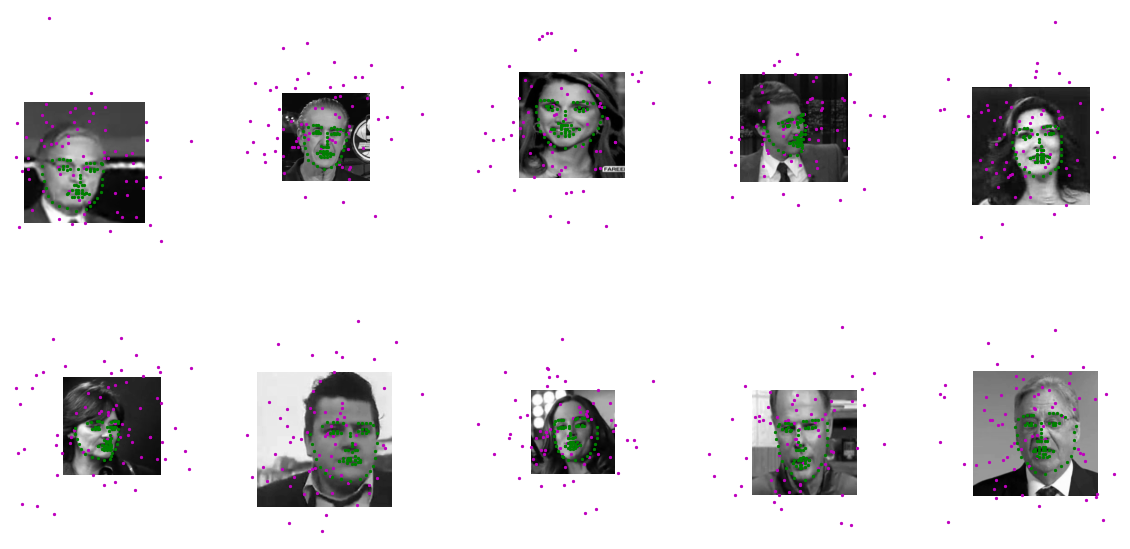

In [14]:
visualize_output(test_images, test_outputs, gt_pts)

#### Note on loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, we will choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

In [15]:
# Defining the loss and optimization
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training and Initial Observation

Now, we'll train on the batched training data from `train_loader` for a number of epochs. To quickly observe the model is training and decide on whether or not we should modify its structure or hyperparameters, we start off with just one or two epochs at first. As the networks is trained, we look how the the model's loss behaves over time. Does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if we change the batch size of the training data or modify the loss function? etc. 

We use these initial observations to make changes to our model and decide on the best architecture before we train for many epochs and create a final model.

In [27]:
def train_net(n_epochs):
    losses = []
    # prepare the net for training
    net.train()

    # loop over the dataset multiple times
    for epoch in tqdm_notebook(range(n_epochs), desc="training"):

        running_loss = 0.0

        # train on batches of data, assumes we already have train_loader
        batch_i = 0
        for data in tqdm_notebook(train_loader, desc="epoch {}".format(epoch)):

            # get the input images and their corresponding labels
            images = data["image"]
            key_pts = data["keypoints"]

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            losses.append(loss.item())
            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()

            if batch_i % 10 == 9:  # print every 10 batches
                tqdm.write(
                    "Epoch: {}, Batch: {}, Avg. Loss: {}".format(
                        epoch + 1, batch_i + 1, running_loss / batch_size
                    )
                )
                running_loss = 0.0

            batch_i += 1
    return losses
    print("Finished Training")

In [28]:
# train the network
n_epochs = 14  # we start at small values, then we increase when we fixed the model structure and hyperparams

losses = train_net(n_epochs)

training:   0%|          | 0/14 [00:00<?, ?it/s]

epoch 0:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 1, Batch: 10, Avg. Loss: 0.0285612007137388
Epoch: 1, Batch: 20, Avg. Loss: 0.027743312995880842
Epoch: 1, Batch: 30, Avg. Loss: 0.029227573424577713
Epoch: 1, Batch: 40, Avg. Loss: 0.028230437077581882
Epoch: 1, Batch: 50, Avg. Loss: 0.027475002920255065


epoch 1:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 2, Batch: 10, Avg. Loss: 0.031031764578074217
Epoch: 2, Batch: 20, Avg. Loss: 0.02736623235978186
Epoch: 2, Batch: 30, Avg. Loss: 0.030744416639208794
Epoch: 2, Batch: 40, Avg. Loss: 0.02957871346734464
Epoch: 2, Batch: 50, Avg. Loss: 0.027565596159547567


epoch 2:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 3, Batch: 10, Avg. Loss: 0.02784590655937791
Epoch: 3, Batch: 20, Avg. Loss: 0.027101988322101533
Epoch: 3, Batch: 30, Avg. Loss: 0.027234137756749988
Epoch: 3, Batch: 40, Avg. Loss: 0.02586653979960829
Epoch: 3, Batch: 50, Avg. Loss: 0.024723129346966743


epoch 3:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 4, Batch: 10, Avg. Loss: 0.028278031153604388
Epoch: 4, Batch: 20, Avg. Loss: 0.031215771101415157
Epoch: 4, Batch: 30, Avg. Loss: 0.02459784026723355
Epoch: 4, Batch: 40, Avg. Loss: 0.024485529982484877
Epoch: 4, Batch: 50, Avg. Loss: 0.024861214449629188


epoch 4:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 5, Batch: 10, Avg. Loss: 0.027496252907440066
Epoch: 5, Batch: 20, Avg. Loss: 0.02633248665370047
Epoch: 5, Batch: 30, Avg. Loss: 0.026762062101624906
Epoch: 5, Batch: 40, Avg. Loss: 0.023077657911926508
Epoch: 5, Batch: 50, Avg. Loss: 0.026983675081282854


epoch 5:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 6, Batch: 10, Avg. Loss: 0.02483540680259466
Epoch: 6, Batch: 20, Avg. Loss: 0.025518751004710793
Epoch: 6, Batch: 30, Avg. Loss: 0.029312308179214597
Epoch: 6, Batch: 40, Avg. Loss: 0.0222571084741503
Epoch: 6, Batch: 50, Avg. Loss: 0.02755091222934425


epoch 6:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 7, Batch: 10, Avg. Loss: 0.02807254600338638
Epoch: 7, Batch: 20, Avg. Loss: 0.031192084774374962
Epoch: 7, Batch: 30, Avg. Loss: 0.028206339571624994
Epoch: 7, Batch: 40, Avg. Loss: 0.021940195583738387
Epoch: 7, Batch: 50, Avg. Loss: 0.02238242607563734


epoch 7:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 8, Batch: 10, Avg. Loss: 0.036318653030321
Epoch: 8, Batch: 20, Avg. Loss: 0.031401732470840216
Epoch: 8, Batch: 30, Avg. Loss: 0.02645049965940416
Epoch: 8, Batch: 40, Avg. Loss: 0.024553306284360588
Epoch: 8, Batch: 50, Avg. Loss: 0.029211344430223107


epoch 8:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 9, Batch: 10, Avg. Loss: 0.029463028302416205
Epoch: 9, Batch: 20, Avg. Loss: 0.02614760200958699
Epoch: 9, Batch: 30, Avg. Loss: 0.025880161905661225
Epoch: 9, Batch: 40, Avg. Loss: 0.02493369486182928
Epoch: 9, Batch: 50, Avg. Loss: 0.022695483174175024


epoch 9:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 10, Batch: 10, Avg. Loss: 0.02601946413051337
Epoch: 10, Batch: 20, Avg. Loss: 0.02484015910886228
Epoch: 10, Batch: 30, Avg. Loss: 0.025169634609483182
Epoch: 10, Batch: 40, Avg. Loss: 0.022256547585129738
Epoch: 10, Batch: 50, Avg. Loss: 0.025716077536344528


epoch 10:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 11, Batch: 10, Avg. Loss: 0.02804301294963807
Epoch: 11, Batch: 20, Avg. Loss: 0.026421882212162018
Epoch: 11, Batch: 30, Avg. Loss: 0.02189602330327034
Epoch: 11, Batch: 40, Avg. Loss: 0.02094022266101092
Epoch: 11, Batch: 50, Avg. Loss: 0.02422574965748936


epoch 11:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 12, Batch: 10, Avg. Loss: 0.02395337645430118
Epoch: 12, Batch: 20, Avg. Loss: 0.02302059473004192
Epoch: 12, Batch: 30, Avg. Loss: 0.02478602109476924
Epoch: 12, Batch: 40, Avg. Loss: 0.025435599265620112
Epoch: 12, Batch: 50, Avg. Loss: 0.026344527839682996


epoch 12:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 13, Batch: 10, Avg. Loss: 0.022456713602878153
Epoch: 13, Batch: 20, Avg. Loss: 0.023161494871601462
Epoch: 13, Batch: 30, Avg. Loss: 0.025559304980561137
Epoch: 13, Batch: 40, Avg. Loss: 0.02528255176730454
Epoch: 13, Batch: 50, Avg. Loss: 0.02364574559032917


epoch 13:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 14, Batch: 10, Avg. Loss: 0.021248414530418813
Epoch: 14, Batch: 20, Avg. Loss: 0.01970349543262273
Epoch: 14, Batch: 30, Avg. Loss: 0.02308529883157462
Epoch: 14, Batch: 40, Avg. Loss: 0.023662548861466348
Epoch: 14, Batch: 50, Avg. Loss: 0.01998629968147725


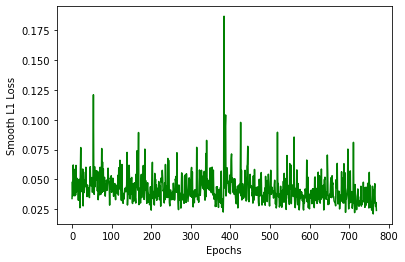

In [29]:
plt.xlabel("Epochs")
plt.ylabel("Smooth L1 Loss")
plt.plot(losses, "g-")

Once we've found a good model (or two), we can save our model so we can load it and use it later!

In [31]:
# !mkdir models

In [32]:
# set the name to something uniqe for each new model
model_dir = "models"
model_name = "second_trained_keypoints_model.pt"
model_path = os.path.join(model_dir, model_name)
# after training, save the  model parameters in the dir 'models'
torch.save(net.state_dict(), model_path)

# Test data

Let's see how the model performs on the previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, we run the trained model on these images to see what kind of keypoints are produced. We can see if the model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [33]:
# load a trained model
# net.load_state_dict(torch.load(model_dir+'keypoints_model.pt'))

In [34]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


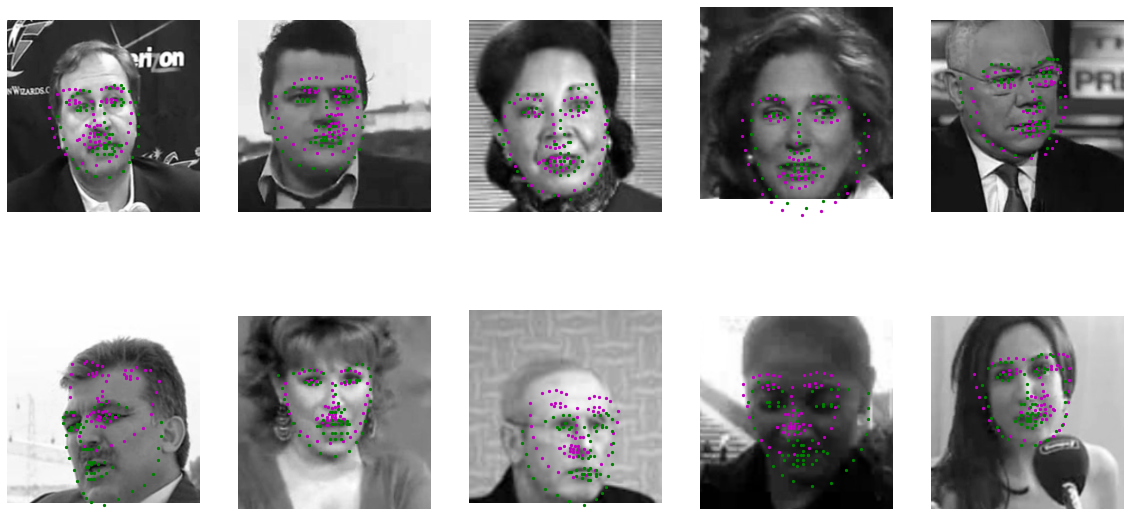

In [35]:
# visualize the test output
visualize_output(test_images, test_outputs, gt_pts)

# Discussion

### Optimizer and Loss Function

I chose Adam optimizer because research has shown that Adam optimizer works well on most tasks, because it integrates many concepts for optimization together. Also, the [research paper](https://arxiv.org/pdf/1710.00977.pdf) on facial keypoints showed from the experiments that Adam optimizer work well on facial keypoits. 

I initially chose to use standard MSE loss, as it works for most tasks and is a common choice of loss to start with. Later, as suggested several expertise, Smooth L1 Loss works better because it is less sensitive to outliers. From observing the photos, I noticed that many photos' ground truth facial keypoints are actually labeled very poorly, some incorrectly. To make sure that our model still works well by not overfitting to outlier data labels, I sticked with the Smooth L1 Loss, which empirically works well.

### Different architectures

I started with a CNN with 4 convolutional layers on custom filter sizes ranging from 64 to 256 increasingly. I added batch normalizations and two fully connected layers with dropouts everywhere. However, they train **extremly slowly** for some reason -- 15min for one iterations within one epoch. The model heavily overfits. 

Then, I tried either adding more fully connected layers, having fewer fully connected layers, having fewer convolutional layers, having dropouts between convolutional layers, and even removing batch normalizations. The model will either heavily underfits or overfits.

Later, I moved on to adapt the architecture by the facial detection [research paper](https://arxiv.org/pdf/1710.00977.pdf). I made my filter sizes samller, starting from 32 to 256 with decreasing kernel sizes. I adapted the idea to add a pooling layer after each convolutional layer. I also added 6 dropouts, one after each convolutional or dense layer operation, with decreasing dropout probabilities from 0.1 to 0.6 (increasing step size 0.1). The model still somewhat underfits. I changed my activation functions from RELU to ELU, and also initialized the weights of fully connected layers according the "xavier uniform".

Then, I found another bug: the order of batch normalization, pooling layers, and activation functions. It turns out that I should apply batch normalizations _before_ both pooling and activations. The result improved dramatically and is much better at fitting, but still non satisfactory. 

Lastly, I chose to add 2D batch normalizations after convolutional operations, which the original paper didn't have due to its huge negative impact on training speed. It improved the model by a lot. After several trails and error, I also added 1D batch normalizations after each fully connected layer, and that did the trick, leading to my best model.


I also experimented with different layers and filters to see what would happen. This didn't give good results, so I ended up using the architecture from the suggested [article](https://arxiv.org/pdf/1710.00977.pdf); the NaimsihNet. 
One of good architectures was: 

input → conv2d → maxpool2d → conv2d → maxpool2d → conv2d → maxpool2d  → conv2d → maxpool2d → dense → dense → dense → output. 
I use both dropout and batch normalization to avoid overfitting. 

I also got good results with transfer learning by fine-tuning the pretrained [resnet18 from pytorch torchvision](https://pytorch.org/docs/stable/torchvision/models.html). This model is much better than my custom model, this isn't obvious just by looking at the test images. The resnet model is much more dynamic and can follow the lips when I move them, the custom model cannot do this, it has more or less overfitted to the shape of a closed mouth. 

### Number of epochs and Batch size

I decided on the number of epochs primarily based on the rate of the training I observed empirically. Rational is that if we have too much epochs, we can do early stopping as soon as we see it starts to overfit -- losses going up. If we have too few epochs, we can just add more epochs to keep training. Eventually, due to time constraint and performance result, I choose to do 14 epochs with early stopping. Early Stopping keeps track of the validation loss, if the loss stops decreasing several epochs in a row the training stops. 

I decided on the batch size based on empirical result on how fast the model is converging and also based on my system memory constraints. If we have a big batch size, it will give me bus errors, where the memory is not enough so the system kills the process. If we have too small of a batch size, the training is slow and underfit. Therefore, after experimenting with different batch sizes from 5 to 128, I ended up using a batch size of 64 for training and 10 for test set.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and we can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, we can see how to extract a single filter (by index) from the first convolutional layer. The filter appears as a grayscale grid.

[[ 0.08469485 -0.22543342  0.02574396 -0.08144885]
 [-0.24881512 -0.11693027 -0.14807045 -0.09692279]
 [-0.05474702 -0.0180312   0.03769759  0.07260651]
 [ 0.26309904  0.19364785  0.19579078 -0.0402486 ]]
(4, 4)


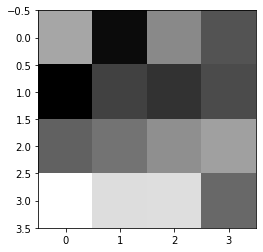

In [36]:
# Get the weights in the first conv layer, "conv1"
# we can change this to reflect the name of other layers
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap="gray")

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in its convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. We can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, it characterizes this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, we will choose a test image and filter it with one of the convolutional kernels in the trained CNN. We look at the filtered output to get an idea what that particular kernel detects.

### Filtering an image to see the effect of a convolutional kernel

First convolutional layer


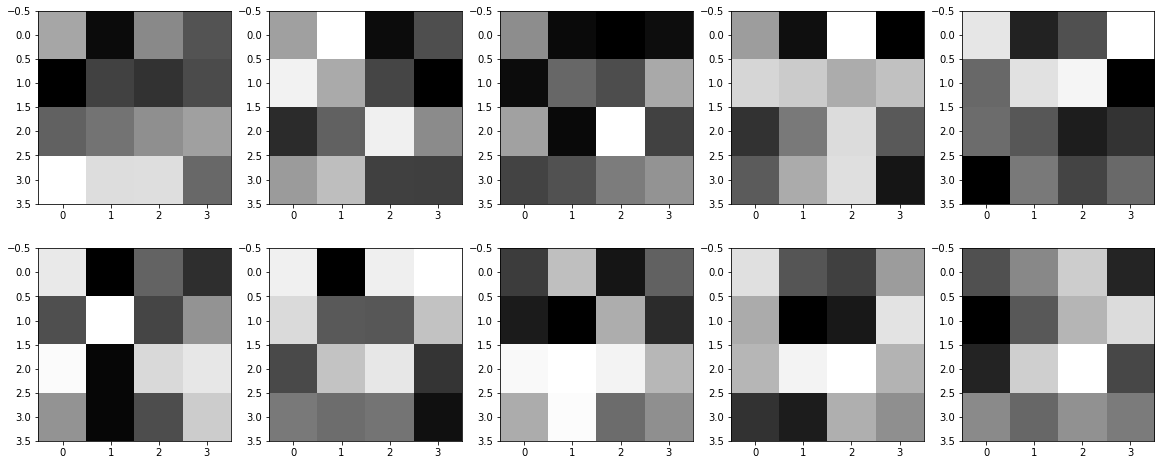

In [37]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig = plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(w[i][0], cmap="gray")

print("First convolutional layer")
plt.show()

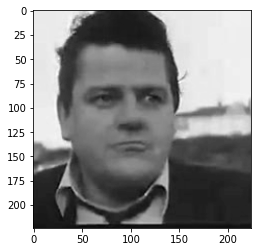

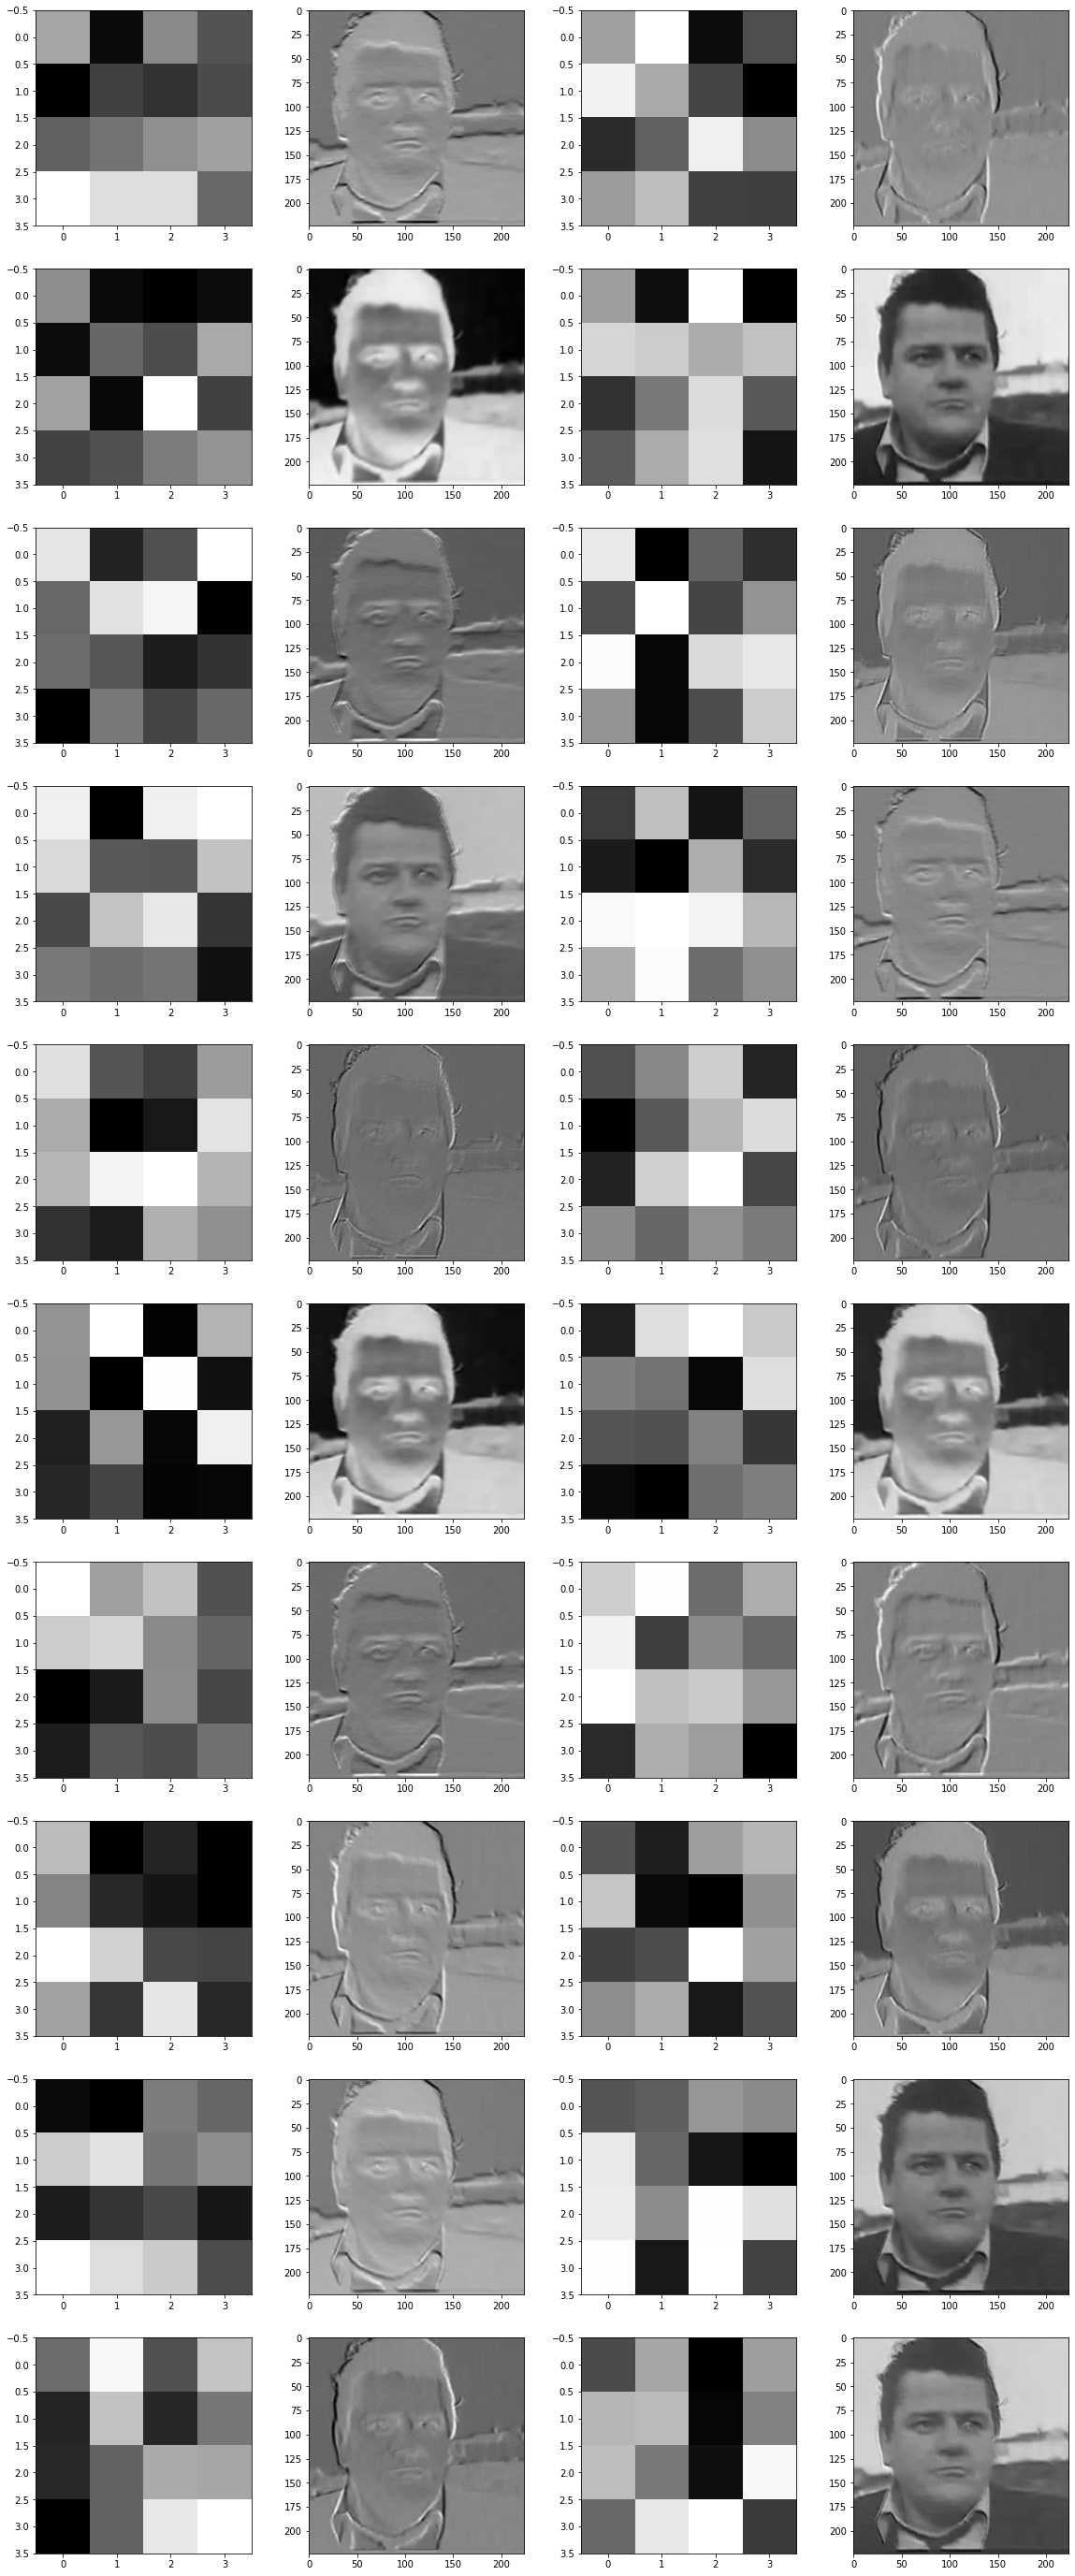

In [40]:
img = np.squeeze(test_images[1])
img = np.array(img)

plt.imshow(img, cmap="gray")
weights = net.conv1.weight.data
w = weights.numpy()

fig = plt.figure(figsize=(20, 50))
columns = 4
rows = 10
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    if (i % 2) == 0:
        plt.imshow(w[int(i / 2)][0], cmap="gray")
    else:
        c = cv2.filter2D(img, -1, w[int((i - 1) / 2)][0])
        plt.imshow(c, cmap="gray")
plt.show()

If we choose one filter from the trained CNN and apply it to a test image, what kind of features does it detect?
If we look at most of the filters, they are picking up lines in the photo, so their purposes probably serve as edge detectors. It probably helps define features such as the curve of the face, etc. for better localizations of the facial keypoints. If we look at filters such as the first one and some on the right column, the eyebrows and lips are highlighted, so they are probably detecting those facial keypoints.

The lower left filter seems to detect dark areas by creating a negative of the image. It has most activation (white color) in the dark areas in the eyes nose and mouth. This filter can help detect the location of the mouth, eyes, and nose. 

---
## Moving on!

Now that we've defined and trained our model (and saved the best model), we are ready to move on to the last notebook, which combines a face detector with our saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!